<a href="https://colab.research.google.com/github/shin1038/shin1038/blob/main/object_clustering_ipynb%EC%9D%98_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*시작 전, 상단 메뉴 '파일' > '드라이브에 사본 저장' 을 선택하여 사본을 가지고 작업을 진행해주시기 바랍니다.*  

# 공지
- csv 파일 제출: dcc2021.clustering@gmail.com (발표 자료는 다른 곳으로 제출하셔야 합니다!!!)
- 리더 보드: https://github.com/High-East/DCC-12-Leader-Board
- 총 제출 횟수는 ***20번*** 입니다.
- 이메일을 보낸 시간을 기준으로, 대회 종료 시각인 ***PM 4:20*** 까지 제출하신 것까지만 인정합니다.
- 평가 지표는 ARI를 사용하고 있습니다. [-1, 1] 사이의 값을 가지며, 1에 가까울수록 높은 성능입니다.


# 기본 환경 세팅
1. **colab 파일**을 사본으로 저장해주세요.
2. [dataset](https://drive.google.com/file/d/1QH71L_uXYm0pRuMwubHIJgSix4y8Fi5I/view?usp=sharing)을 바로가기 추가해주세요.

# 문제
> Q. 2040년, 집에서도 인공지능이 도입된 로봇이 사용되기 시작했습니다. 집을 치워주는 로봇 "깔끔이"가 있습니다. 아쉽게도 "깔끔이"는 특정 물건이 어떤 것인지는 모릅니다. 하지만, A와 B가 같은 물건인지는 인식할 수 있습니다. "깔끔이"는 특히, 아이들이 사는 집에서 인기가 많습니다. 아이들이 어지럽힌 집을 "깔끔이"가 잘 치울 수 있도록 군집 알고리즘을 만들어보세요!


# 데이터 설명
훈련 데이터(Train Data): 637개의 레이블이 없는 사물 데이터  
평가 데이터(Test Data): 훈련 데이터와 동일  
피쳐 설명(Feature): (128, 128) 크기의 컬러 사진  
목표: 가장 적합한 군집의 개수를 찾고, 높은 군집 정확도 얻기  


# 구글 드라이브 마운트

In [ ]:
# 구글 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 폴더 이동
import os
ROOT = '/content/gdrive/MyDrive'  # 변경하지 마세요. 단, MyDrive가 오류난다면, My\ Drive로 적으세요.
DIR = 'Colab Notebooks'  # 데이터가 있는 위치를 적으세요.

PATH = os.path.join(ROOT, DIR)
os.chdir(PATH)
print(f"현재 경로: {PATH}")

현재 경로: /content/gdrive/MyDrive/Colab Notebooks


In [ ]:
# 할당 받은 GPU 확인
!nvidia-smi

Sat Nov  6 05:52:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 패키지 임포트

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, activations
from tensorflow.keras import optimizers
from sklearn.cluster import KMeans

import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from ipywidgets import interact

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {tf.keras.__version__}")

tensorflow version: 2.6.0
keras version: 2.6.0


# 커스텀 함수 정의

In [ ]:
# Visualization function
def show_img(dataset, predict, idx):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB))
    ax1.set_title("Raw image")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(predict[idx], cv2.COLOR_BGR2RGB))
    ax2.set_title("Reconstructed image")
    plt.show()

# Elbow method
def elbow_method(X, a, b):
    sse = []
    for i in range(a, b + 1):
        km = KMeans(n_clusters=i, init='k-means++', random_state=1207)
        km.fit(X)
        sse.append(km.inertia_)
    plt.figure(figsize=(8,6))
    plt.plot(range(a, b + 1), sse, marker='o', c='black')
    plt.xlabel("Number of clusters", fontsize=12)
    plt.ylabel("SSE", fontsize=12)
    plt.title("Elbow method", fontsize=15)
    plt.grid(linestyle='--')
    plt.show()

# 데이터 로드

In [ ]:
# 데이터 로드
path = "/content/dataset.npy"
dataset = np.load(path)
dataset = np.float32(dataset / 255)  # 데이터 정규화

# 데이터 shape 확인
print(f"dataset shape: {dataset.shape}")

dataset shape: (637, 128, 128, 3)


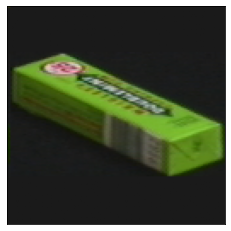

In [ ]:
# 이미지 확인
idx = 2
plt.imshow(cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB))
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

# 차원 축소
- PCA와 같은 다른 차원 축소 기법을 사용해도 괜찮습니다.

## 오토인코더

In [ ]:
# 인코더
encoder = models.Sequential([
          layers.InputLayer(input_shape=(256, 256, 3)),
          layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=256, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          # layers.Flatten(),
          # layers.Dense(units=128, activation='relu')
          ],
          name='Encoder')

# 모델 구조 시각화
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_85 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
re_lu_88 (ReLU)              (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_86 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_89 (ReLU)              (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        1849

In [ ]:
# 디코더
decoder = models.Sequential([
          layers.InputLayer(input_shape=(8,8,256)),  # 인코더의 마지막 output shape을 입력하세요.
          # layers.Dense(units=512, activation='relu'),
          # layers.Reshape(target_shape=(8, 8, 8)),
          layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
            layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=3, kernel_size=1, strides=1, activation='tanh'),
         ],
          name='Decoder')

# 모델 구조 시각화
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_52 (Conv2DT (None, 16, 16, 256)       590080    
_________________________________________________________________
batch_normalization_90 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
re_lu_93 (ReLU)              (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_53 (Conv2DT (None, 32, 32, 128)       295040    
_________________________________________________________________
batch_normalization_91 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
re_lu_94 (ReLU)              (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_54 (Conv2DT (None, 64, 64, 64)        7379

In [ ]:
# 오토인코더: 인코더 + 디코더 구조
autoencoder = models.Sequential([
              layers.InputLayer(input_shape=(256, 256, 3), name='Input'),
              encoder,  # 인코더
              decoder])  # 디코더

## 학습
- Optimizer, loss 및 모든 하이퍼파라미터를 자유롭게 조정하며 실험해보세요.
- Optimizer 참고 자료 1 : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- Optimizer 참고 자료 2: https://keras.io/ko/optimizers/
- Loss 참고자료 1: https://www.tensorflow.org/api_docs/python/tf/keras/losses
- Loss 참고자료 2: https://keras.io/ko/losses/

In [ ]:
# 하이퍼파라미터 설정
lr = 1e-03
optimizer = optimizers.Adam(learning_rate=lr)
loss = 'mse'
epochs = 50
batch_size = 16

# 모델 컴파일(=optimizer, loss 세팅)
autoencoder.compile(optimizer=optimizer,
                    loss=loss)

# 학습
autoencoder.fit(x=dataset, y=dataset, epochs=epochs, batch_size=batch_size)

Epoch 1/50
40/40 [==============================] - 3s 36ms/step - loss: 0.0038
Epoch 2/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0035
Epoch 3/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0035
Epoch 4/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0032
Epoch 5/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0031
Epoch 6/50
40/40 [==============================] - 1s 35ms/step - loss: 0.0029
Epoch 7/50
40/40 [==============================] - 1s 35ms/step - loss: 0.0029
Epoch 8/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0029
Epoch 9/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0034
Epoch 10/50
40/40 [==============================] - 1s 35ms/step - loss: 0.0030
Epoch 11/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0030
Epoch 12/50
40/40 [==============================] - 1s 34ms/step - loss: 0.0027
Epoch 13/50
40/40 [==================

## 복원된 이미지 확인

In [ ]:
# 오토인코더를 통해 얻은 이미지(=복원된 이미지)
max_len = 10
predict = autoencoder(dataset[:max_len])

# 시각화
slider = widgets.IntSlider(min=0, max=max_len, step=1, value=0)
interact(lambda idx: show_img(dataset[:max_len], predict.numpy(), idx), idx=slider)

interactive(children=(IntSlider(value=0, description='idx', max=10), Output()), _dom_classes=('widget-interact…

<function __main__.<lambda>>

# 클러스터링(K-means)
- 클러스터링 기법 변경하셔도 상관 없습니다.

## Latent vector 생성

In [ ]:
# Extract latent vector(mini-batch version, OOM 방지)
batch_size = 64
latent_vec = []
num_batch = len(dataset) // batch_size

for i in range(num_batch + 1):
    batch_set = dataset[i * batch_size:(i + 1) * batch_size]
    latent_vec.append(encoder(batch_set).numpy())

latent_vec = np.concatenate(latent_vec, axis=0)

if np.ndim(latent_vec) != 2:
    latent_vec = np.reshape(latent_vec, [len(dataset), -1])

## Cluster 개수 결정

In [ ]:
# Elbow method를 통해서 최적의 cluster 개수(K)를 찾아보세요.
# K는 15이하입니다.
# latent_vec의 크기가 클수록 런타임이 오래 걸리니 참고하세요.
start = 1
end = 15
elbow_method(latent_vec, start, end)

KeyboardInterrupt: ignored

In [ ]:
# K-Means clustering
n_clusters = 5  # elbow method 등을 이용해서 K를 결정해보세요.
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1207).fit(latent_vec)
y_pred = kmeans.labels_

# 제출 파일(csv) 생성

In [ ]:
# 저장할 폴더 만들기
SAVE_PATH = os.path.join(PATH, "output")
if not os.path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
else:
  pass

In [ ]:
# 제출 파일 만들기
team = "crystals"  # 반드시 자신이 속한 팀명을 적어주세요.
suffix = 5  # 자신이 제출한 파일을 알아볼 수 있는 접미사를 적어주세요. 이전에 제출한 파일과 동일하면 안됩니다.

# 이 밑은 수정하지 마세요.
# timestamp = datetime.today().strftime("%Y%m%d%H%M%S")
sub = pd.DataFrame(y_pred, columns=["y_pred"])
sub.to_csv(os.path.join(SAVE_PATH, f"./{team}_{suffix}.csv"), index=False)

# 제출
1. output 폴더 안에 있는 제출할 csv을 다운받아 주세요.
2. dcc2021.clustering@gmail.com로 csv파일을 첨부해서 보내주세요. (제목과 내용은 상관 없음)
3. 1-2분 후에 [리더보드](https://github.com/High-East/DCC-12-Leader-Board)에서 확인해주세요.


# 재공지
- 총 제출 횟수는 ***20번*** 입니다.
- 이메일을 보낸 시간을 기준으로, 대회 종료 시각인 ***PM 4:20*** 까지 제출하신 것까지만 인정합니다.
- 평가 지표는 ARI를 사용하고 있습니다. [-1, 1] 사이의 값을 가지며, 1에 가까울수록 높은 성능입니다.
- 발표 자료는 추후에 공지되는 이메일로 보내주세요.